In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.metrics import confusion_matrix,f1_score
from sklearn.metrics import accuracy_score,precision_score,recall_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
data=pd.read_csv("spam_email.csv")

In [3]:
data.head()

,subject,message,label
0,job posting - apple-iss research center,content - length : 3386 apple-iss research cen...,0
1,NaN,"lang classification grimes , joseph e . and ba...",0
2,query : letter frequencies for text identifica...,i am posting this inquiry for sergei atamas ( ...,0
3,risk,a colleague and i are researching the differin...,0
4,request book information,earlier this morning i was on the phone with a...,0


In [4]:
data.shape

(2893, 3)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2893 entries, 0 to 2892
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   subject  2831 non-null   object
 1   message  2893 non-null   object
 2   label    2893 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 67.9+ KB


In [6]:
data.describe()

,label
count,2893.000000
mean,0.166263
std,0.372381
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


EDA

In [54]:
data.isnull().sum()

subject    62
message     0
label       0
dtype: int64

In [55]:
data=data.fillna("")

In [56]:
data['mail']=data['subject'].str.cat(data['message'], sep =" ") 

In [57]:
data.head()

,subject,message,label,mail
0,job posting - apple-iss research center,content - length : 3386 apple-iss research cen...,0,job posting - apple-iss research center conten...
1,,"lang classification grimes , joseph e . and ba...",0,"lang classification grimes , joseph e . and b..."
2,query : letter frequencies for text identifica...,i am posting this inquiry for sergei atamas ( ...,0,query : letter frequencies for text identifica...
3,risk,a colleague and i are researching the differin...,0,risk a colleague and i are researching the dif...
4,request book information,earlier this morning i was on the phone with a...,0,request book information earlier this morning ...


In [58]:
data.drop(columns=['subject','message'],axis=1,inplace=True)

In [59]:
data.head()

,label,mail
0,0,job posting - apple-iss research center conten...
1,0,"lang classification grimes , joseph e . and b..."
2,0,query : letter frequencies for text identifica...
3,0,risk a colleague and i are researching the dif...
4,0,request book information earlier this morning ...


In [60]:
print ('label counts','\n',data.label.value_counts())

label counts 
 0    2412
1     481
Name: label, dtype: int64


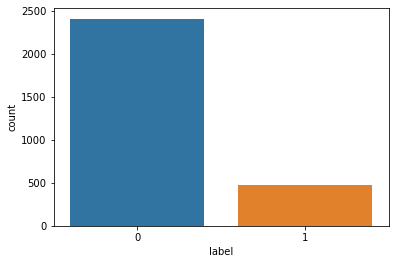

In [61]:
sns.countplot(x='label',data=data)

In [62]:
#New column for Length of mail
data['length'] = data.mail.str.len()
data.head(2)

,label,mail,length
0,0,job posting - apple-iss research center conten...,2896
1,0,"lang classification grimes , joseph e . and b...",1801


Data Preprocessing

In [63]:
# Convert all mail to lower case
data['mail'] = data['mail'].str.lower()

In [67]:
# Replace email addresses with 'email'
data['mail'] = data['mail'].str.replace(r'^.+@[^\.].*\.[a-z]{2,}$',
                                 'emailaddress')

# Replace URLs with 'webaddress'
data['mail'] = data['mail'].str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$',
                                  'webaddress')

# Replace money symbols with 'moneysymb' (£ can by typed with ALT key + 156)
data['mail'] = data['mail'].str.replace(r'£|\$', 'dollers')
    
# Replace 10 digit phone numbers (formats include paranthesis, spaces, no spaces, dashes) with 'phonenumber'
data['mail'] = data['mail'].str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$',
                                  'phonenumber')

    
# Replace numbers with 'numbr'
data['mail'] = data['mail'].str.replace(r'\d+(\.\d+)?', 'numbr')

# Remove punctuation
data['mail'] = data['mail'].str.replace(r'[^\w\d\s]', ' ')

# Replace whitespace between terms with a single space
data['mail'] = data['mail'].str.replace(r'\s+', ' ')

# Remove leading and trailing whitespace
data['mail'] = data['mail'].str.replace(r'^\s+|\s+?$', '')

In [68]:
data.head()

,label,mail,length
0,0,job posting apple iss research center content ...,2896
1,0,lang classification grimes joseph e and barbar...,1801
2,0,query letter frequencies for text identificati...,1486
3,0,risk a colleague and i are researching the dif...,329
4,0,request book information earlier this morning ...,1071


In [69]:
# Remove stopwords
import string
import nltk
from nltk.corpus import  stopwords

stop_words = set(stopwords.words('english') + ['u', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure'])

data['mail'] = data['mail'].apply(lambda x: ' '.join(
    term for term in x.split() if term not in stop_words))

In [70]:
# New column (clean_length) after puncuations,stopwords removal
data['clean_length'] = data.mail.str.len()
data.head()

,label,mail,length,clean_length
0,0,job posting apple iss research center content ...,2896,2217
1,0,lang classification grimes joseph e barbara f ...,1801,1454
2,0,query letter frequencies text identification p...,1486,1109
3,0,risk colleague researching differing degrees r...,329,215
4,0,request book information earlier morning phone...,1071,654


In [71]:
# Total length removal
print ('Origian Length', data.length.sum())
print ('Clean Length', data.clean_length.sum())

Origian Length 9439299
Clean Length 6849015


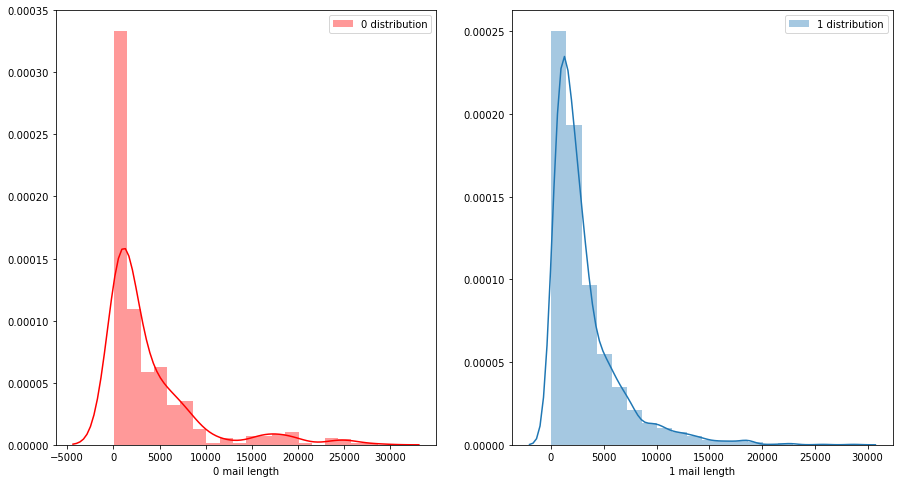

In [74]:
# Mail distribution BEFORE cleaning
f,ax = plt.subplots(1,2,figsize = (15,8))

sns.distplot(data[data['label']==1]['length'],bins=20,ax=ax[0],label='0 distribution',color='r')

ax[0].set_xlabel('0 mail length')
ax[0].legend()

sns.distplot(data[data['label']==0]['length'],bins=20,ax=ax[1],label='1 distribution')
ax[1].set_xlabel('1 mail length')
ax[1].legend()

plt.show()

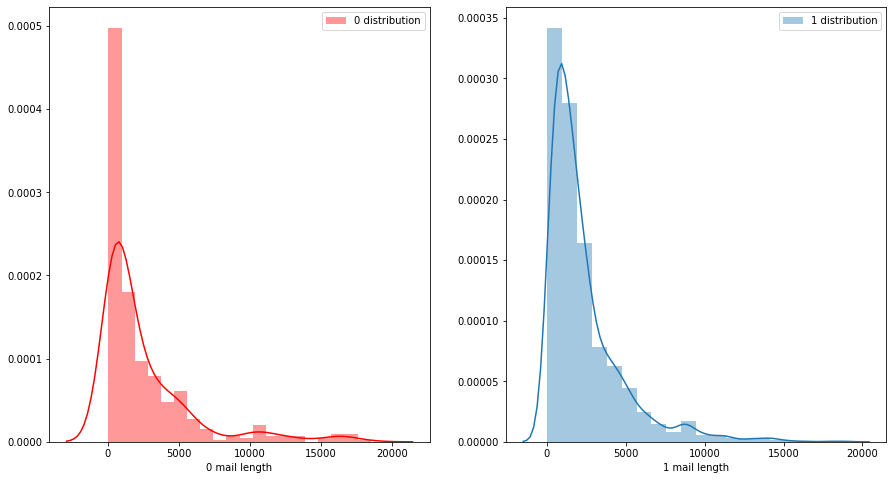

In [75]:
# Mail distribution AFTER cleaning
f,ax = plt.subplots(1,2,figsize = (15,8))

sns.distplot(data[data['label']==1]['clean_length'],bins=20,ax=ax[0],label='0 distribution',color='r')
ax[0].set_xlabel('0 mail length')
ax[0].legend()

sns.distplot(data[data['label']==0]['clean_length'],bins=20,ax=ax[1],label='1 distribution')
ax[1].set_xlabel('1 mail length')
ax[1].legend()

plt.show()

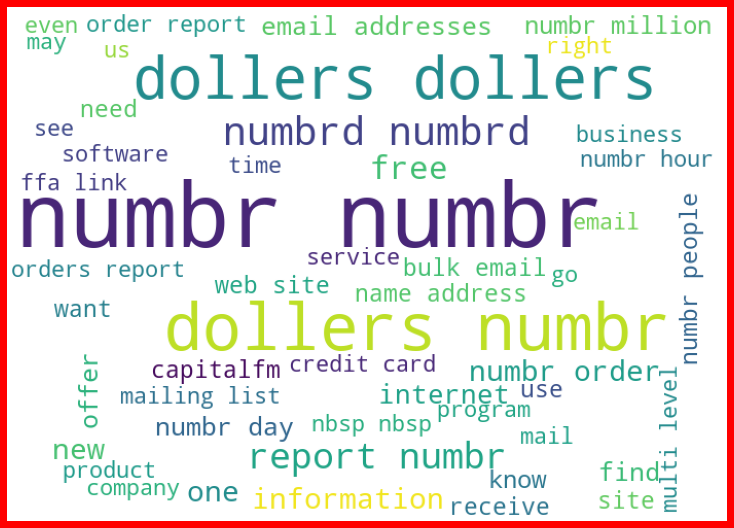

In [78]:
#Getting sense of loud words in 1
from wordcloud import WordCloud


spams = data['mail'][data['label']==1]

spam_cloud = WordCloud(width=700,height=500,background_color='white',max_words=50).generate(' '.join(spams))

plt.figure(figsize=(10,8),facecolor='r')
plt.imshow(spam_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

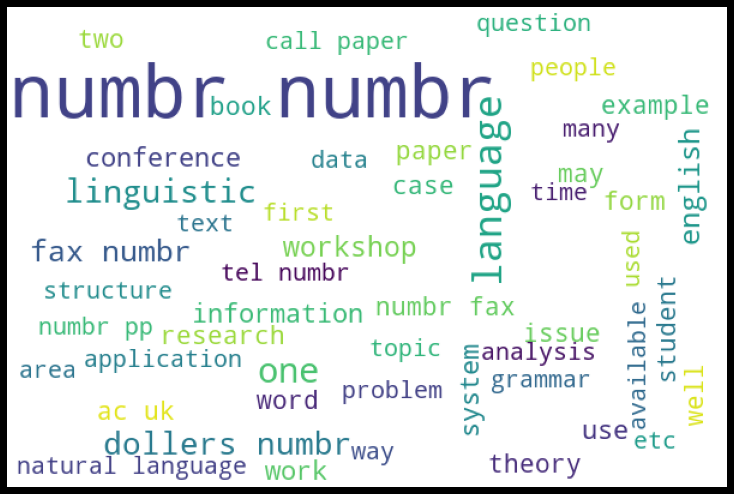

In [79]:
#Getting sense of loud words in 0 

hams = data['mail'][data['label']==0]
spam_cloud = WordCloud(width=600,height=400,background_color='white',max_words=50).generate(' '.join(hams))
plt.figure(figsize=(10,8),facecolor='k')
plt.imshow(spam_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [80]:
# 1. Convert text into vectors using TF-IDF
# 2. Instantiate MultinomialNB classifier
# 3. Split feature and label
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

tf_vec = TfidfVectorizer()

naive = MultinomialNB()

features = tf_vec.fit_transform(data['mail'])

X = features
y = data['label']

In [81]:
# Train and predict
X_train,x_test,Y_train,y_test = train_test_split(X,y,random_state=42)

naive.fit(X_train,Y_train)

y_pred= naive.predict(x_test)

print ('Final score = > ', accuracy_score(y_test,y_pred))

Final score = >  0.8370165745856354


In [82]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      1.00      0.91       585
           1       1.00      0.15      0.26       139

    accuracy                           0.84       724
   macro avg       0.92      0.58      0.59       724
weighted avg       0.86      0.84      0.78       724



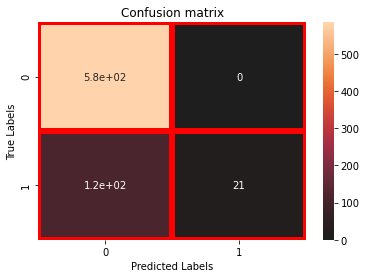

In [85]:
# plot confusion matrix heatmap
conf_mat = confusion_matrix(y_test,y_pred)

ax=plt.subplot()

sns.heatmap(conf_mat,annot=True,ax=ax,linewidths=5,linecolor='r',center=0)

ax.set_xlabel('Predicted Labels');ax.set_ylabel('True Labels')

ax.set_title('Confusion matrix')
ax.xaxis.set_ticklabels(['0','1'])
ax.yaxis.set_ticklabels(['0','1'])
plt.show()

In [86]:
conf_mat

array([[585,   0],
       [118,  21]], dtype=int64)